# CS 342 Homework 3 - Recurrent Neural Networks

Welcome to your third homework for CS 342! This problem set covers Recurrent Neural Networks. There are 3 main problems, each with several sub-questions. For coding questions, fill in the missing parts (usually denoted `...`). Please answer all questions in-line, being as brief and precise as possible. You will not need any libraries that aren't already imported here. This code can be run on your local machine.

Please follow <a href="https://pytorch.org">these instructions</a> to install pytorch.

Submission: Upload your jupyter notebook on canvas. The deadline is 2pm April 6, 2023 (i.e. before class begins).

Good luck!

Enter your name and EID in the following block:

If you worked with anyone on this homework, please list them below:

Kunal Dhawan  
Aten Kumar

In [1]:
# Run this block to load important libraries and set things up
import torch
from torch import nn
import numpy as np
import scipy.signal

%matplotlib inline
import matplotlib.pyplot as plt
%config InlineBackend.figure_format='retina'

## Problem 1. Copy task (16 pts)

In this first problem you will train an RNN to solve the _copy task_, a fairly standard test used to show that RNNs can learn to remember information. The task of the network is to memorize an $n$-dimensional binary pattern that it sees on the first timepoint, and then output exactly that same pattern after a $d$-timepoint delay when the network sees a "recall cue". 

The input and output of the RNN will be $n+1$-dimensional binary vectors, where the first dimension is the recall cue and the other $n$ dimensions constitute the pattern. Inputs during the delay period will be all zeros. On the final timepoint, only the recall cue dimension will be active.

Run the next cell to see an example of what the copy task inputs look like.

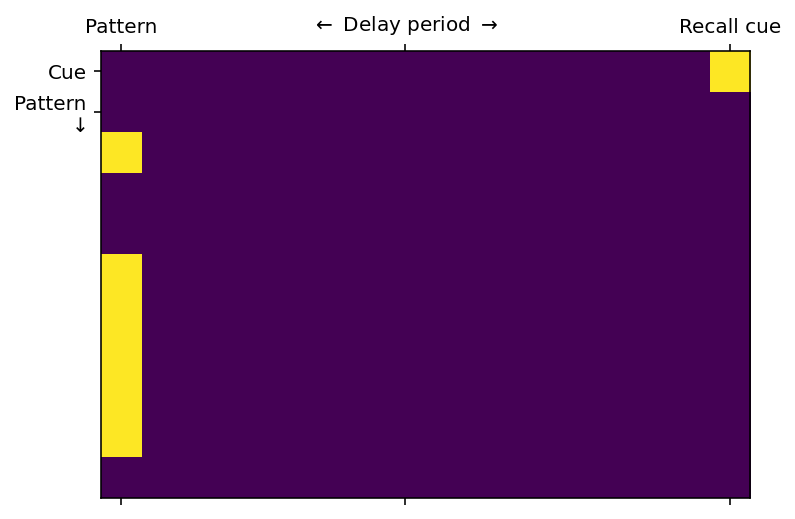

In [2]:
def make_copy_input(pattern_dim, delay):
    """Generate copy task inputs with `pattern_dim` dimensions
    and a `delay`-timepoint delay period.
    """
    pattern = (torch.rand(pattern_dim) > 0.5).float()
    
    sequence = torch.zeros((delay + 1, 1, pattern_dim + 1))
    sequence[0,0,1:] = pattern
    sequence[delay,0,0] = 1
    
    return sequence, pattern

# visualize an example sequence
sequence, pattern = make_copy_input(10, 15)
plt.matshow(sequence.squeeze().detach().T);
plt.xticks([0, 7, 15], ["Pattern", r"$\leftarrow$ Delay period $\rightarrow$", "Recall cue"]);
plt.yticks([0, 1], ["Cue", "Pattern\n"+r"$\downarrow$"]);

The ideal output of the network would be all zeros at every timpoint but the last, and then the exact pattern at the last timepoint:

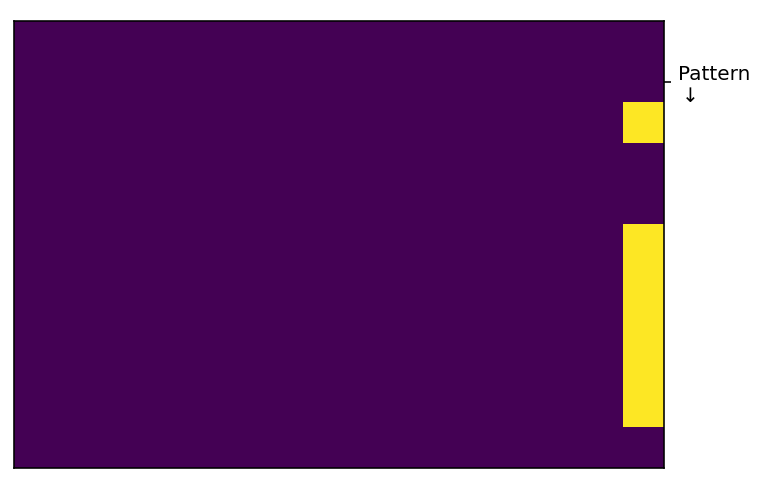

In [3]:
ideal_output = torch.zeros_like(sequence)
ideal_output[-1] = sequence[0]
plt.matshow(ideal_output.squeeze().detach().T);
plt.xticks([])
plt.yticks([1], ["Pattern\n"+r"$\downarrow$"]);
plt.gca().yaxis.tick_right()

Your goal is to train an RNN (well, an LSTM) to solve this problem. Let's do it!

### Q 1.1: Define your model (2 pts)
Define your model as the `CopyNet` class. Use a single-layer LSTM with `ndim` input dimensions (should be pattern length + 1 for the cue) and `nhidden` units. Then add an output layer to project from the length-`nhidden` output vectors of the LSTM to `ndim` dimension for the output.

In [4]:
class CopyNet(nn.Module):
    def __init__(self, ndim, nhidden):
        super(CopyNet, self).__init__()
        self.lstm = nn.LSTM(input_size=ndim, hidden_size=nhidden)
        self.fc = nn.Linear(in_features=nhidden, out_features=ndim)
    
    def forward(self, x, h):
        x, _ = self.lstm(x, h)
        x = self.fc(x)
        return x

### Q 1.2: Train it to solve the copy task with pattern length $n=10$ and delay $d=10$ (5 pts)
Use Adam for training and MSE loss. Keep track of the loss after each step, and then plot your loss curve at the end. (Plot log loss to see what's happening more clearly.)

Hints:
* You might need to play with the loss a bit. Applying different amounts of weight to the delay period (when you want the model to output zeros) and the final step (where you want it to output the pattern) might help.
* Start each run (i.e. each sequence) with a fresh state (all zeros).
* On each iteration, **use the `make_copy_input` function to generate a new pattern**. You don't want the model to just memorize one pattern!
* Start with 64 hidden units in your LSTM. 
* You will probably need to train for several thousand iterations to get the model to converge.

In [5]:
hidden_units = 64
inner_dim = (1, 1, hidden_units)
h0 = torch.zeros(inner_dim)
c0 = torch.zeros(inner_dim)

In [11]:
from tqdm.notebook import tqdm
import torch.nn.functional as F

def train_network(model, criterion, optimizer, nepoch, pattern_dim, delay):
    losses = []
    try:
        for epoch in tqdm(range(nepoch + 1)):
            if epoch % 1000 == 0:
                print('EPOCH %d'%epoch)
            optimizer.zero_grad()
            
            sequence, pattern = make_copy_input(pattern_dim, delay)
            output = model.forward(sequence, (h0, c0))
            
            ideal_output = torch.zeros_like(sequence)
            ideal_output[-1] = sequence[0]
            
            loss = criterion(output, ideal_output)
            losses.append(loss.item())
            loss.backward()
            optimizer.step()

            if epoch % 1000 == 0:
                print('{:>12s} {:>7.5f}'.format('Loss:', loss.item()))
                print()
    except KeyboardInterrupt:
        print('Exiting from training early')
    return losses

In [12]:
def run_network(model, pattern_dim, delay, nepochs):
    criterion = nn.MSELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=6e-4)
    losses = train_network(model, criterion, optimizer, nepochs, pattern_dim, delay)
    return losses

  0%|          | 0/40000 [00:00<?, ?it/s]

EPOCH 0
       Loss: 0.02468

EPOCH 1000
       Loss: 0.02029

EPOCH 2000
       Loss: 0.02075

EPOCH 3000
       Loss: 0.02125

EPOCH 4000
       Loss: 0.01556

EPOCH 5000
       Loss: 0.01458

EPOCH 6000
       Loss: 0.01701

EPOCH 7000
       Loss: 0.01720

EPOCH 8000
       Loss: 0.01484

EPOCH 9000
       Loss: 0.00668

EPOCH 10000
       Loss: 0.00294

EPOCH 11000
       Loss: 0.00209

EPOCH 12000
       Loss: 0.00316

EPOCH 13000
       Loss: 0.00152

EPOCH 14000
       Loss: 0.00059

EPOCH 15000
       Loss: 0.00096

EPOCH 16000
       Loss: 0.00096

EPOCH 17000
       Loss: 0.00058

EPOCH 18000
       Loss: 0.00012

EPOCH 19000
       Loss: 0.00076

EPOCH 20000
       Loss: 0.00029

EPOCH 21000
       Loss: 0.00015

EPOCH 22000
       Loss: 0.00032

EPOCH 23000
       Loss: 0.00041

EPOCH 24000
       Loss: 0.00018

EPOCH 25000
       Loss: 0.00035

EPOCH 26000
       Loss: 0.00027

EPOCH 27000
       Loss: 0.00006

EPOCH 28000
       Loss: 0.00008

EPOCH 29000
       Loss: 0.

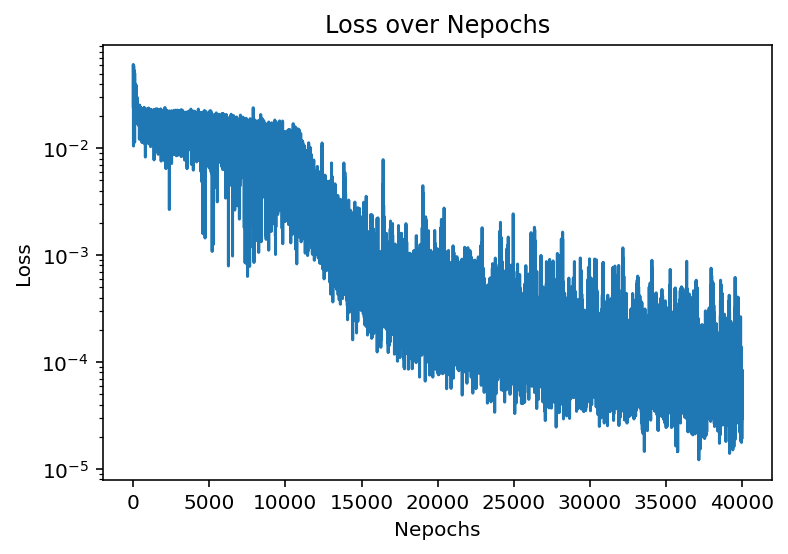

In [35]:
pattern_dim = 10
delay = 10
nepochs = 40_000
model = CopyNet(ndim=pattern_dim + 1, nhidden=hidden_units)
losses = run_network(model, pattern_dim, delay, nepochs)

plt.semilogy(np.arange(1, nepochs + 1, 1), losses)
plt.title("Loss over Nepochs")
plt.xlabel("Nepochs")
plt.ylabel("Loss")
plt.show()

### Q 1.3: Visualize the model output (2 pts)
Generate a new sequence with the same parameters ($n=10, d=10$), plot the sequence, and then plot the model outputs for that sequence.

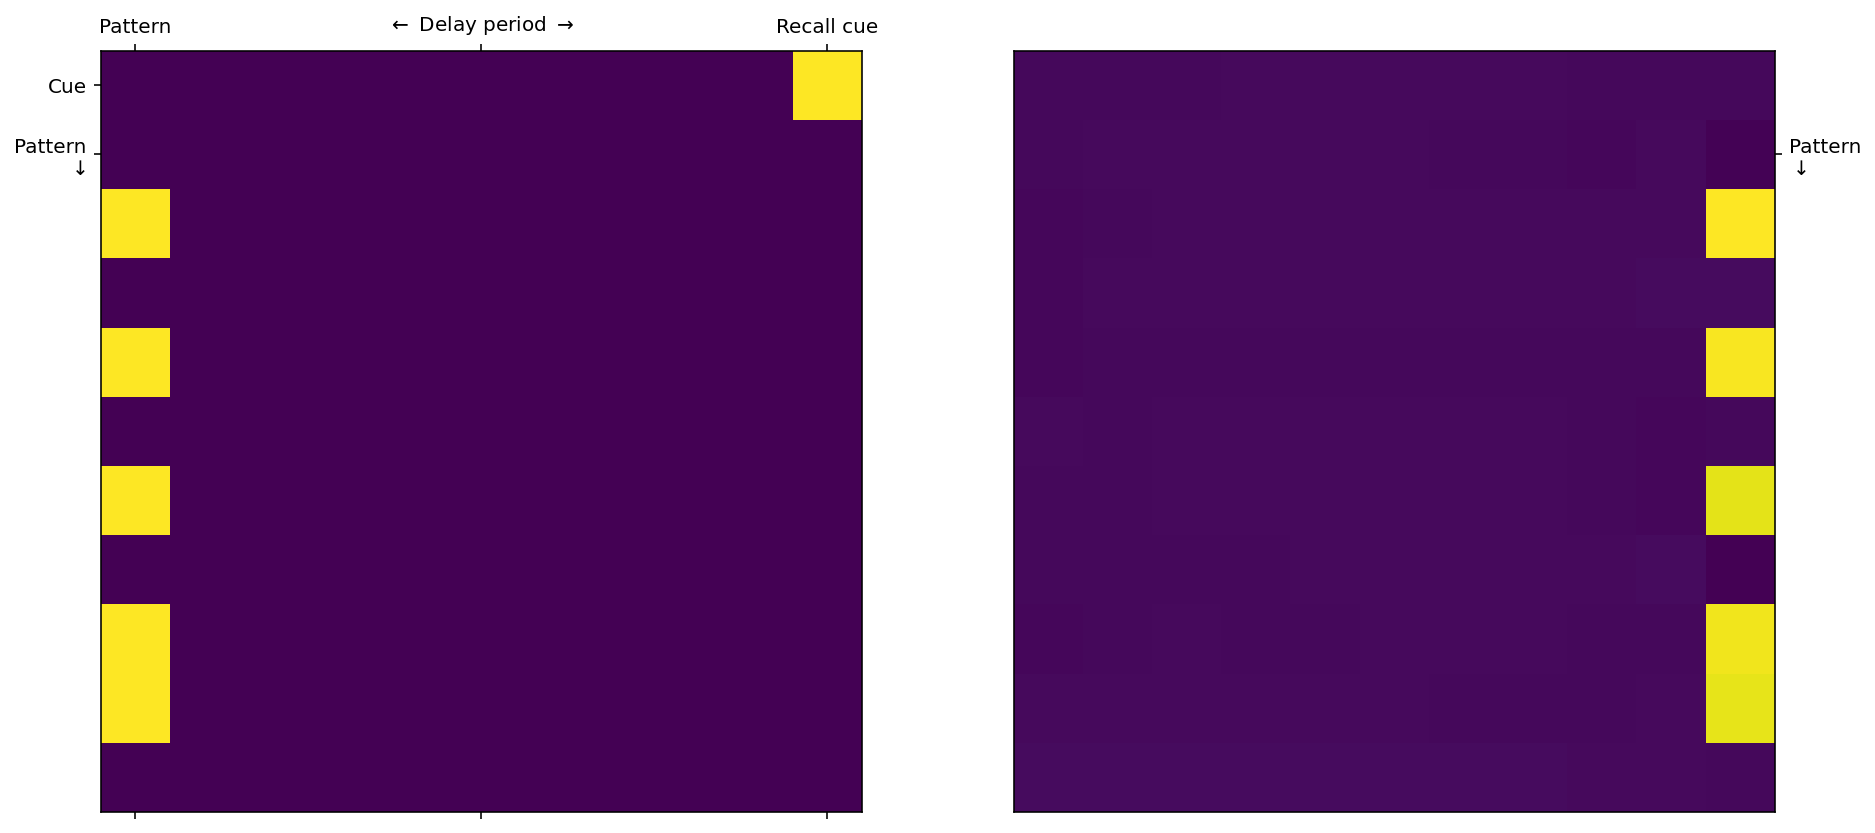

In [36]:
def plot_example_sequence(): 
    fig, ax = plt.subplots(1, 2, figsize=(15, 10))

    # visualize an example sequence
    sequence, pattern = make_copy_input(pattern_dim=10, delay=10)
    ax[0].matshow(sequence.squeeze().detach().T);
    ax[0].set_xticks([0, delay // 2, delay], ["Pattern", r"$\leftarrow$ Delay period $\rightarrow$", "Recall cue"]);
    ax[0].set_yticks([0, 1], ["Cue", "Pattern\n"+r"$\downarrow$"]);

    output = model(sequence, (h0, c0))
    ax[1].matshow(output.squeeze().detach().T);
    ax[1].set_xticks([])
    ax[1].set_yticks([1], ["Pattern\n"+r"$\downarrow$"]);
    fig.gca().yaxis.tick_right()

plot_example_sequence()

### Q 1.4: Test the model on different delay lengths (3 pts)
Now test the model on different delay length $d=5$ through $d=100$. Generate 10 sequences for each delay length and then record the average MSE *only for the last timestep*. If you write a function to do this, it will help you on the next problem. Plot the results, then answer the question below.

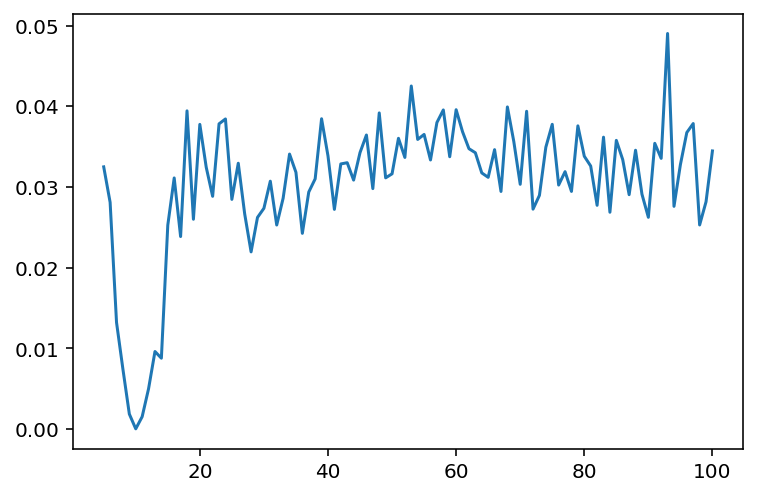

In [43]:
def MSELoss(model, criterion, delay):
    num_tests = 10
    tot_loss = 0
    for _ in range(num_tests):
        sequence, pattern = make_copy_input(pattern_dim=10, delay=delay)
        output = model(sequence, (h0, c0))
        
        ideal_output = torch.zeros_like(sequence)
        ideal_output[-1] = sequence[0]
            
        loss = criterion(output, ideal_output)
        tot_loss += loss.item()
        
    return tot_loss / num_tests

delays = range(5, 101)
losses = [MSELoss(model, criterion, delay) for delay in delays]

plt.plot(delays, losses)

### Q 1.5: Train a new model that has an easier time generalizing across delay lengths (4 pts)
We can make it much easier for the model to learn how to generalize across delay lengths by simply training it with a variety of delay lengths. Here, train a new model but on each iteration choose a random delay length between 5 and 40. After every 5000 iterations, test the model on delay lengths 5 through 400. Plot the results. If you've done things correctly, your model should have ~perfect performance for arbitrarily long delays.

In [102]:
from tqdm.notebook import tqdm
import torch.nn.functional as F

def train_generalized_network(model, criterion, optimizer, nepoch, pattern_dim):
    losses = []
    gen_losses = []
    try:
        for epoch in tqdm(range(nepoch + 1)):
            if epoch % 1000 == 0:
                print('EPOCH %d'%epoch)
            optimizer.zero_grad()
            
            sequence, pattern = make_copy_input(pattern_dim=10, delay=np.random.randint(5, 41))
            output = model.forward(sequence, (h0, c0))
            
            ideal_output = torch.zeros_like(sequence)
            ideal_output[-1] = sequence[0]
            
            loss = criterion(output, ideal_output)
            losses.append(loss)
            loss.backward()
            optimizer.step()

            if epoch % 1000 == 0:
                print('{:>12s} {:>7.5f}'.format('Loss:', loss.item()))
                print()
                
            if epoch % 5000 == 0:
                delays = range(5, 401)
                gen_losses.append([MSELoss(model, criterion, delay) for delay in delays])
                
    except KeyboardInterrupt:
        print('Exiting from training early')
    return losses, gen_losses

In [103]:
def run_generalized_network(model, criterion, pattern_dim, nepochs):
    optimizer = torch.optim.Adam(model.parameters(), lr=6e-4)
    losses, gen_losses = train_generalized_network(model, criterion, optimizer, nepochs, pattern_dim)
    return losses, gen_losses

In [101]:
pattern_dim = 10
nepochs = 50_000
model = CopyNet(ndim=pattern_dim + 1, nhidden=hidden_units)
criterion = nn.MSELoss()
losses, gen_losses = run_generalized_network(model, criterion, pattern_dim, nepochs)

  0%|          | 0/50001 [00:00<?, ?it/s]

EPOCH 0
       Loss: 0.03045

EPOCH 1000
       Loss: 0.00613

EPOCH 2000
       Loss: 0.00650

EPOCH 3000
       Loss: 0.00872

EPOCH 4000
       Loss: 0.01040

EPOCH 5000
       Loss: 0.00683

EPOCH 6000
       Loss: 0.01785

EPOCH 7000
       Loss: 0.00971

EPOCH 8000
       Loss: 0.01092

EPOCH 9000
       Loss: 0.00683

EPOCH 10000
       Loss: 0.00676

EPOCH 11000
       Loss: 0.00606

EPOCH 12000
       Loss: 0.00346

EPOCH 13000
       Loss: 0.01784

EPOCH 14000
       Loss: 0.00531

EPOCH 15000
       Loss: 0.00870

EPOCH 16000
       Loss: 0.00785

EPOCH 17000
       Loss: 0.00717

EPOCH 18000
       Loss: 0.00351

EPOCH 19000
       Loss: 0.00182

EPOCH 20000
       Loss: 0.00402

EPOCH 21000
       Loss: 0.00155

EPOCH 22000
       Loss: 0.00814

EPOCH 23000
       Loss: 0.00251

EPOCH 24000
       Loss: 0.00216

EPOCH 25000
       Loss: 0.00167

EPOCH 26000
       Loss: 0.00023

EPOCH 27000
       Loss: 0.00079

EPOCH 28000
       Loss: 0.00095

EPOCH 29000
       Loss: 0.

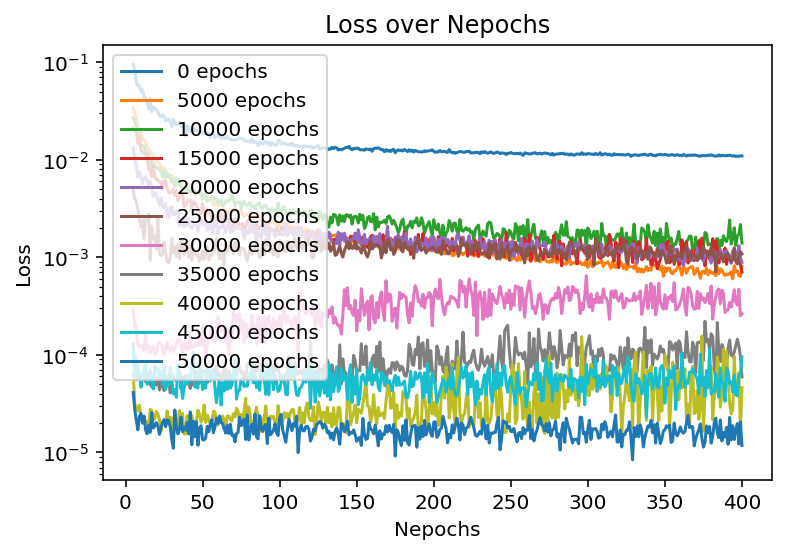

In [107]:
for e in range(0, nepochs + 1, 5000):
    plt.semilogy(range(5, 401), gen_losses[e // 5000], label=f'{e} epochs')
    plt.title("Loss over Nepochs")
    plt.xlabel("Nepochs")
    plt.ylabel("Loss")

plt.legend()
plt.show()

AxesSubplot(0.125,0.125;0.775x0.755)


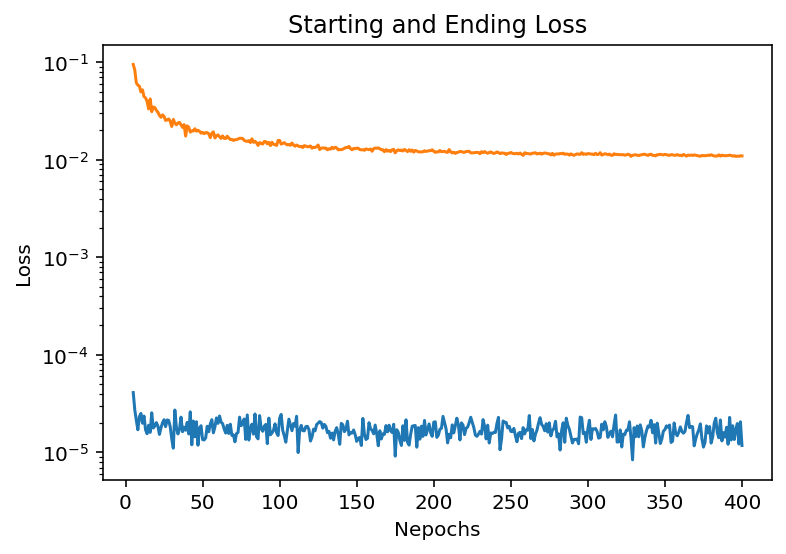

In [127]:
ax = plt.gca()
print(ax)

for i in range(-1, 1):
    ax.semilogy(range(5, 401), gen_losses[i])
plt.title("Starting and Ending Loss")
plt.xlabel("Nepochs")
plt.ylabel("Loss")

plt.show()

### _Q 1.BONUS_: Examine/plot the model weights and activations to figure out _how_ it's solving the copy task (+5 pts)
Plot the weights (from the LSTM: recurrent weights & input weights, from the output layer: output weights), hidden states, and (if you can work out how to do it, but see Problem 2.4 below) the cell states.

Hint:
* Remember that the ordering of the units in the LSTM is arbitrary. Re-ordering the weights before plotting them can change the result from uninterpretable schmoo to something beautiful.

In [ ]:
...

## Problem 2. Character-level language model (17 pts)
For this problem you will define and train a _character-level language model_ (char-LM). This model reads a string of text, like `['T', 'h', 'i', 's', ' ', 'p', 'r', 'o', 'b', 'l', 'e', 'm', ' ', 's', 'h', 'o', 'u', 'l', 'd', ' ', 'b', 'e', ' ', 'f', 'u']` and predicts that the next character should be `n` (for example).

(Note that this is different from the language models we talked about in class, which operated on _words_ instead of _characters_. The reason is that word-level language models tend to be very memory-intensive, so are more difficult to work with on normal hardware. But character-level models are still interesting!)

You will be training your char-LM on the classic novel "War and Peace" by Leo Tolstoy (this choice inspired by the [classic paper from Karpathy et al.](https://arxiv.org/abs/1506.02078)). (Also it's a really good book, you should read it.) Let's first load in the data and take a look.

In [130]:
with open("HW3_data/warandpeace.txt", encoding='utf8') as f:
    text = f.read()

print(text[:300]) # print first 300 characters

CHAPTER I

“Well, Prince, so Genoa and Lucca are now just family estates of the
Buonapartes. But I warn you, if you don’t tell me that this means war,
if you still try to defend the infamies and horrors perpetrated by that
Antichrist—I really believe he is Antichrist—I will have nothing
more to do w


Now let's preprocess the data a little further. What we're doing here is:
1. Finding all the unique characters (the book uses some weird ones)
2. Creating mappings from characters to integers (and vice versa)
3. (Adjusting the mappings to remove newlines, which are simply annoying.)
4. Converting the text to a (long) array of integers

In [131]:
chars = sorted(list(set(text))) # find unique chars

# create mappings
char_to_idx = {ch:i for i,ch in enumerate(chars)}
idx_to_char = {i:ch for i,ch in enumerate(chars)}

# remove newlines!
char_to_idx['\n'] = char_to_idx[' ']

data_size = len(text)
vocab_size = len(chars)

# mapping text to integer array
data_array = torch.zeros(data_size)
for ii in range(data_size):
    data_array[ii] = char_to_idx[text[ii]]

# printing some stuff
print("Characters:", chars)
print("Number of unique characters:", vocab_size)
print("Number of characters in book:", data_size)

Characters: ['\n', ' ', '!', '(', ')', '*', ',', '-', '.', '/', '0', '1', '2', '3', '4', '5', '6', '7', '8', '9', ':', ';', '=', '?', 'A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N', 'O', 'P', 'Q', 'R', 'S', 'T', 'U', 'V', 'W', 'X', 'Y', 'Z', 'a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z', 'À', 'Á', 'É', 'à', 'á', 'â', 'ä', 'æ', 'ç', 'è', 'é', 'ê', 'ë', 'í', 'î', 'ï', 'ó', 'ô', 'ö', 'ú', 'ü', 'ý', 'œ', '—', '‘', '’', '“', '”']
Number of unique characters: 104
Number of characters in book: 3201636


### Q 2.1: Define your model (2 pts)
Define your model in the class `CharLM`. This model has three parameters: `input_size` (the number of dimensions in the input), `output_size` (the number of dimensions in the output), and `hidden_size` (the number of dimensions in your LSTM). This model should have three layers:
1. An `Embedding` layer, which maps character integers to length-`input_size` vectors
2. An `LSTM` layer, which has `hidden_size` units and does all the fun stuff
3. A `Linear` output layer, which maps from `hidden_size` to `output_size`

Hints:
* `input_size` and `output_size` should be the same
* Remember to return the hidden state and cell state in the forward function (you need this!)
* 1 hidden layer in the LSTM is probably all you need for this problem

In [244]:
class CharLM(nn.Module):
    def __init__(self, input_size, output_size, hidden_size):
        super(CharLM, self).__init__()
        self.embedding = nn.Embedding(num_embeddings=vocab_size, embedding_dim=input_size)
        self.lstm = nn.LSTM(input_size=input_size, hidden_size=hidden_size, batch_first=True)
        self.fc = nn.Linear(in_features=hidden_size, out_features=output_size)
        
    def forward(self, x, hidden_state):
        x = self.embedding(x)
        x, hidden_state = self.lstm(x, hidden_state)
        x = self.fc(x)
        return x, hidden_state

### Q 2.2: Train your model using truncated BPTT (5 pts)
Now train that model! Let's use truncated BPTT with a sequence length `seq_len=100`. That means that on each training step, the model reads the next 100 characters from the text & generates outputs, then you compute loss & backpropagate, before stepping ahead to the next sequence.

The training process is going to look like this:
1. Create initial hidden- and cell-states (all zeros), and initialize an integer `data_ptr` to point at the beginning of the text.
2. Run the model on `data_array[data_ptr:data_ptr+seq_len]` using your stored states. Get outputs and store the new states (you'll use these as the input on the next iteration!).
3. Compute cross-entropy loss between those outputs and the targets. The target for each output should be the _next_ character in the text. (Getting the dimensions right for this is a little tricky, but you can do it all in one call to a `CrossEntropyLoss` object.)
4. Backprop & take an optimizer step.
5. Increment `data_ptr` by `seq_len`. If you've gone too far (i.e. past the end of the book), you're done with an epoch! Reset `data_ptr=0` before continuing on the next epoch.
6. Save the average loss at this step to an array so you can plot it later.
7. Go back to step 2.

You should use `hidden_size=256`, compute loss with `CrossEntropyLoss`, and use Adam with learning rate 0.01 for optimization. In 2 or 3 epochs your loss should reach around 1.24. (To get a less noisy measure of the loss you can average it over a few sequences, like 20.)

**BONUS (+2 pts)**: This training is probably pretty slow. If you want it to go faster, you could train your model in batches. For example, instead of just reading from the beginning to the end of the book, you might read from 50 different places in the book at the same time. Depending on how you implement this, it could be indexing hell, so beware.

In [264]:
# num_sections * section_size ~ num characters in book
num_sections = 100
section_size = 32_000
seq_len = 100

hidden_size = 256
inner_dim = (1, num_sections, hidden_size)
h0 = torch.zeros(inner_dim)
c0 = torch.zeros(inner_dim)
nepoch = 5

In [265]:
def batch(data, data_ptr):
    batched_data = []
    batched_targets = []
    for section in range(num_sections):
        str_start = section_size * section + data_ptr
        batched_data.append(data[str_start:str_start + seq_len])
        batched_targets.append(data[str_start + 1:str_start + seq_len + 1])
        
    batched_data = torch.tensor(np.row_stack(batched_data)).type(torch.LongTensor)
    batched_targets = torch.tensor(np.row_stack(batched_targets)).type(torch.LongTensor)
    return batched_data, batched_targets

In [266]:
from tqdm.notebook import tqdm
import torch.nn.functional as F
import random

def train_lang_network(model, criterion, optimizer, nepoch, data):
    losses = []
    try:
        for epoch in tqdm(range(nepoch)):
            print('EPOCH %d'%epoch)
            raw_losses = []
            hidden_state = (h0, c0)
            
            for data_ptr in range(0, section_size, seq_len):
                optimizer.zero_grad()
                batched_data, batched_targets = batch(data, data_ptr)
                
                outputs, hidden_state = model(batched_data, (hidden_state[0].detach(), hidden_state[1].detach()))
                outputs = torch.flatten(outputs, end_dim=1)
                targets = torch.flatten(batched_targets)
                
                loss = criterion(outputs, targets)
                raw_losses.append(loss.item())
                loss.backward()
                optimizer.step()
                
            loss = np.average(raw_losses)
            losses.append(loss)
            print('{:>12s} {:>7.5f}'.format('Loss:', loss))
            print()
    except KeyboardInterrupt:
        print('Exiting from training early')
    return losses

In [267]:
model = CharLM(input_size=vocab_size, output_size=vocab_size, hidden_size=hidden_size)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

losses = train_lang_network(model, criterion, optimizer, nepoch, data_array)

  0%|          | 0/5 [00:00<?, ?it/s]

EPOCH 0
       Loss: 1.71609

EPOCH 1
       Loss: 1.35505

EPOCH 2
       Loss: 1.28764

EPOCH 3
       Loss: 1.25315

EPOCH 4
       Loss: 1.23277



### Q 2.3: Generate text from your model (5 pts)
Your language model predicts the next character from the previous characters, which means you can use this model to generate arbitrarily long sequences of text. Let's write a function to do that!

The process will work like this:
1. You will be given a **context string**, like _"Tilling the field"_. Let's say these characters are $x_1, x_2, ..., x_t$.
2. Starting with all-zero initial states, run your model on the context string to produce outputs $o_1, ..., o_t$, hidden state $h_t$ and cell state $c_t$.
3. Use the output at the last step, $o_t$, to generate a new character, $x'_{t+1}$. (See below for more info on how to sample.)
4. Input the new character $x'_{t+1}$ to the model along with the hidden state $h_t$ and cell state $c_t$, generating the output $o_{t+1}$ and new hidden and cell states $h_{t+1}$ and $c_{t+1}$.
5. Go back to step 3 (but obviously with $o_{t+1}$ instead of $o_t$, etc.), repeat until you have enough new characters.

#### Sampling from the output distribution
Due to the cross-entropy loss, each element of the output vector represents the log probability that the corresponding character is the next in the story, i.e. $o_{t,k} = \log P(x_{t+1}=\mbox{idx_to_char}(k) | x_1, ..., x_t)$. There are several strategies you might use to sample a new character from this distribution. You should implement these three in your code, and test all of them:
1. Choose the most likely character (i.e. the one with the highest probability). You might think this would be the best! It's the most likely output. Try it and find out!
2. $P(x_{t+1}=\mbox{idx_to_char}(k) | x_1, ..., x_t)$ is a probability distribution, so you could just sample from it. Use `torch.multinomial` to do this.
3. Use the ["top-k" method](https://arxiv.org/abs/1904.09751): for some value k (something like 3, 5, or 10), set all _but_ the top k probabilities to zero, then re-normalize the distribution to sum 1.

In [293]:
# write the text generating function
def generate_text_from(model, length, context, sampling_method):
    """Sample `length` characters from the character-LM `model` following
    the given `context`.
    
    `sampling_method` should be "argmax", "multinomial", or "topk".
    
    Return (or print?) the result.
    """
    pred_str = ''
    inner_dim = (1, 1, hidden_size)
    hidden_state = (torch.zeros(inner_dim), torch.zeros(inner_dim))
    # Creating the context array from the size and char_to_idx array
    context_sample = torch.tensor([char_to_idx[context[i]] for i in range(len(context))]).type(torch.LongTensor)
    
    for c in range(length):
        context_sample = torch.unsqueeze(context_sample, 0)
        output, hidden_state = model.forward(context_sample, (hidden_state[0].detach(), hidden_state[1].detach()))
        output = torch.flatten(output, end_dim=1)
        output = output[-1]
        softmax = nn.Softmax(dim=0)
        output = softmax(output)
        pred=''
        
        if sampling_method == "argmax":
            pred = max([(i, c) for i, c in enumerate(output)], key=lambda x:x[1])[0]
        elif sampling_method == "multinomial":
            pred = torch.multinomial(output, 1).item()
        elif sampling_method == "topk":
            k = 5
            values, indices = torch.topk(output, k)
            pred = indices[torch.multinomial(softmax(values), 1).item()].item()
        else:
            print('Invalid Sampling Method')
            break
            
        pred_str += idx_to_char[pred]
        context_sample = torch.tensor([pred]).type(torch.LongTensor)
    
    return pred_str

In [307]:
# generate 100 characters with each of the three methods using the context "Tilling the field"
sampling_methods = ['argmax', 'multinomial', 'topk']

for sampling_method in sampling_methods:
    print('Generating text using sampling method', sampling_method)
    pred_str = generate_text_from(model, 100, 'Tilling the field', sampling_method)
    print('Predicted String:', pred_str)
    print()

Generating text using sampling method argmax
Predicted String:  of the same time to the same time to the same time to the same time to the same time to the same ti

Generating text using sampling method multinomial
Predicted String:  in express it was the mile became to avoid in Moscow right and only because. On instant what addres

Generating text using sampling method topk
Predicted String:  fel,’ to too sis, be athaps only: “I am! Ales o’ll.’.) Before hidalle will. To le ten me went is tr



### Q 2.4: Visualize cell states (5 pts)
Finally, let's use the same method from [Karpathy et al.](https://arxiv.org/abs/1506.02078) Figure 2 to visualize cell states in our trained character-LM. You're going to generate cell states for the first 1000 characters of _War & Peace_ and then visualize them. 

We'll provide the visualization function `visualize_cell_states`, but you'll need to: 
1. generate the cell states for each character,
2. look at the cell states for several (many?) different units, and
3. find one that you can interpret. You'll need to describe what your selected unit is doing!

Generating cell states is tricky, because the `torch.nn.LSTM` object doesn't give you cell states, only hidden states. So you'll need to step through your input one character at time, saving each cell state as you go, much like the generation problem above.

Hint:
* To find an interpretable unit, you might want to try to find which units are important to the model. Important units might have big weights, or maybe removing them makes the model much worse. Or you could just try at random, there are only 256 of them :)

In [308]:
from IPython.display import display, HTML
to_hex = plt.cm.colors.to_hex

def visualize_cell_states(string, states, cmap=plt.cm.coolwarm):
    """Makes a pretty visualization of the given `string`, which should be N
    characters long, using the values in `states`, which should be a length-N
    array.
    """
    norm = plt.Normalize(vmin=states.min(), vmax=states.max())
    colors = cmap(norm(states)*0.5 + 0.25)
    print(colors.shape)
    
    output = '<div style="font-family:monospace">'
    for char,color in zip(string, colors):
        output += '<span style="background-color:%s">%s</span>'%(to_hex(color),char)
    
    output += '</div>'
    display(HTML(output))

In [481]:
test_len = 1000
cell_states = []
test_str = [idx_to_char[c.item()] for c in data_array[:test_len]]
inner_dim = (1, 1, hidden_size)
hidden_state = torch.zeros(inner_dim)
cell_state = torch.zeros(inner_dim)

with torch.no_grad():
    for c in data_array[:test_len]:
        input_char = torch.tensor([[c]]).type(torch.LongTensor)
        _, (hidden_state, cell_state) = model(input_char, (hidden_state, cell_state))
        cell_states.append(torch.flatten(cell_state).detach().numpy())

cell_states = np.array(cell_states)

cell_weights = list(model.named_parameters())[2][1][1]
cell_weights = torch.tensor(list(map(abs, cell_weights)))
print('Highest Cell Weights', torch.topk(cell_weights, 10).indices)
variances = [np.var(np.array(state_list[:,i])) for i in range(cell_states.shape[1])]
print('Lowest Cell Variances:', torch.topk(torch.tensor(variances), 10, largest=False).indices)

visualize_cell_states(test_str, np.array(cell_states[:,243]))

Highest Cell Weights tensor([ 68, 146, 224, 108,  48,  83, 221, 250,  46, 204])
Lowest Cell Variances: tensor([249,  57,  56, 103, 126, 139, 215,  40,  69, 243])
(1000, 4)


Describe what a selected unit is doing here:

On Cell 243, we see that the cell has large jumps in activation mostly at punctuation marks. This might show that the cell is signaling when punctuation should show up, so if a punctuation just happened, this cell starts to go against more punctuation, but as we get farther from the recent punctuation, we see the cell gradually waning in activation. This would lead to a better signal for punctuation until the next punctuation mark.


## Problem 3. Hopfield Network (6 pts)
Finally, let's do something light and easy: a Hopfield network. Hopfield nets are recurrent neural networks that act as _associative memory_: if it starts at some state $s$ the model should converge (after some iterations) to the stored memory that's closest to the initial state $s$.

The dynamics are simple, and use the "signum function" nonlinearity (which evaluates to -1 if the input is less than zero, and +1 if it's more than zero):
$$ s' = \mbox{sign}(W \cdot s) $$
where $W$ is the weight matrix and only set of parameters.

Let's first load the data that you'll be using, a set of binary images forming letters. Each one is a flattened version of a 9x7 image.

(26, 63)


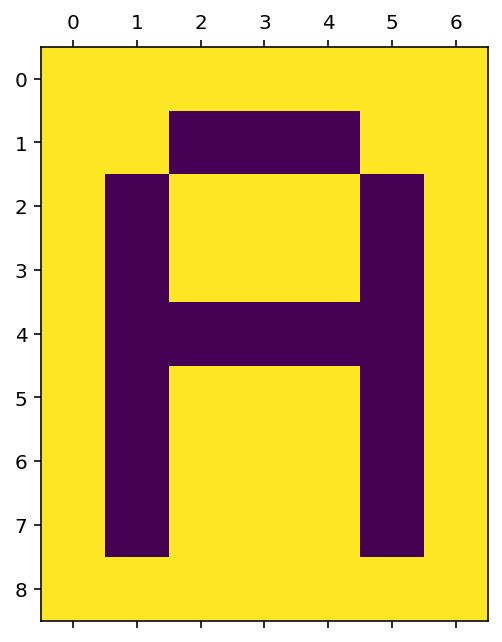

In [3]:
patterns = np.load('HW3_data/hopfield_patterns.npz')['arr_0']
print(patterns.shape)

plt.matshow(patterns[0].reshape(9,7));

### Q 3.1: Implement Hebbian learning (3 pts)
First let's implement the simplest version: Hebbian learning. Here the weights are determined exactly by the patterns without any actual "learning". Suppose we have $N$ patterns, $x^1, ..., x^N$, each consisting of $M$ bits, $x^p_1, ..., x^p_M$. Then the weights are given as
$$W_{i,j} = \sum_{p=1}^{N} x^p_i x^p_j$$
Implement this using 2, 4, 8, or 26 different patterns from the training set. Then test how many of the patterns are _stable_, that is, if you start the network at that pattern, will it change? Report the number of stable patterns for each number of stored patterns. (You should probably try a few different random combinations of patterns.)

Note: unlike pretty much every other problem in this homework (and class), this model is so simple you can implement it using numpy. You don't need pytorch, you don't need autodiff, you don't need any fancy optimizers. Just matrix multiplication!

In [31]:
def hebbian_learning(patterns, n, m):
    weights = np.zeros((m, m))
    
    indices = np.random.randint(len(patterns), size=n)
    sampled_patterns = patterns[indices,:]

    for pattern in sampled_patterns:
        for i in range(m):
            for j in range(m):
                weights[i][j] += pattern[i] * pattern[j]
    return weights / n

In [41]:
from tqdm.notebook import tqdm
import torch.nn.functional as F

num_samples = [2, 4, 8, 26]
m = patterns.shape[1]
for num_sample in num_samples:
    stable_patterns = 0
    weights = hebbian_learning(patterns, num_sample, m)
    
    for pattern in patterns:
        pred_pattern = np.sign(np.dot(weights, pattern))
        if np.all(pred_pattern == pattern):
            stable_patterns += 1
    print("Stable patterns produced with Hebbian Learning using", num_sample, "sample patterns:", stable_patterns)

Stable patterns produced with Hebbian Learning using 2 sample patterns: 2
Stable patterns produced with Hebbian Learning using 4 sample patterns: 3
Stable patterns produced with Hebbian Learning using 8 sample patterns: 0
Stable patterns produced with Hebbian Learning using 26 sample patterns: 2


### Q 3.2: Implement the Storkey learning rule (3 pts)
Next let's implement the slightly more complicated version, [Storkey learning](https://en.wikipedia.org/wiki/Hopfield_network#Storkey_learning_rule). This tends to work a bit better, but usually needs several iterations. Again, you should use this rule to train the network with 2, 4, 8, or 26 patterns, and then test stability.

_Hint: If you're lazy, you can implement it using nested for loops like the equations in the wikipedia page. If you're clever you can figure out how to do it in one line._

In [37]:
def storkey_learning(patterns, n, m):
    weights = np.zeros((m, m))
    
    indices = np.random.randint(len(patterns), size=n)
    sampled_patterns = patterns[indices,:]

    for pattern in sampled_patterns:
        for i in range(m):
            for j in range(m):
                h_ji = np.sum([weights[j][k] * pattern[k] for k in range(m) if k != i and k != j])
                h_ij = np.sum([weights[i][k] * pattern[k] for k in range(m) if k != i and k != j])
                weights[i][j] += (pattern[i] * pattern[j] - pattern[i] * h_ji - pattern[j] * h_ij) / n
    
    return weights / n

In [43]:
from tqdm.notebook import tqdm
import torch.nn.functional as F

num_samples = [2, 4, 8, 26]
m = patterns.shape[1]
for num_sample in num_samples:
    stable_patterns = 0
    
    weights = storkey_learning(patterns, num_sample, m)
    
    for pattern in patterns:
        pred_pattern = np.sign(np.dot(weights, pattern))
        if np.all(pred_pattern == pattern):
            stable_patterns += 1
    print("Stable patterns produced with Storkey Learning using", num_sample, "sample patterns:", stable_patterns)

Stable patterns produced with Storkey Learning using 2 sample patterns: 0
Stable patterns produced with Storkey Learning using 4 sample patterns: 0
Stable patterns produced with Storkey Learning using 8 sample patterns: 0
Stable patterns produced with Storkey Learning using 26 sample patterns: 4
